In [ ]:
---
format:
    html:
        self-contained: true
        embed-resources: true
title: "Practice Activity 8.1"
---

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [2]:
!pip install palmerpenguins

In [14]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal
from palmerpenguins import load_penguins

In [4]:
penguins = load_penguins()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [5]:
penguins = penguins.dropna()

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [6]:
X = penguins[["species", "island", "bill_length_mm","flipper_length_mm","body_mass_g","sex","year"]]
y = penguins["bill_depth_mm"]


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)

In [7]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

# Best multiple linear regression model

In [8]:
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
   ("elastic_net", ElasticNet())]
).set_output(transform="pandas")

param = {
    "elastic_net__alpha": np.arange(0.001, 0.01, 0.1),
    "elastic_net__l1_ratio": np.arange(.10, .20, .30)
    }

gscv = GridSearchCV(lr_pipeline_1, param, cv = 5, scoring='r2')

gscv.fit(X_train, y_train)
y_pred = gscv.predict(X_test)
mse1=np.sqrt(mean_squared_error(y_test, y_pred))
mse1

0.8157767711729802

# kNN model K=3

In [9]:
lr_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("knn_regression", KNeighborsRegressor(n_neighbors=3))]
)

lr_pipeline_2.fit(X_train, y_train)
y_pred = lr_pipeline_2.predict(X_test)
mse2=np.sqrt(mean_squared_error(y_test, y_pred))
mse2

0.808535811655958

# kNN model K=10

In [10]:
lr_pipeline_3 = Pipeline(
  [("preprocessing", ct),
  ("knn_regression", KNeighborsRegressor(n_neighbors=10))]
)

lr_pipeline_3.fit(X_train, y_train)
y_pred = lr_pipeline_3.predict(X_test)
mse3=np.sqrt(mean_squared_error(y_test, y_pred))
mse3

0.7845714632539096

# Decision tree model

In [11]:
lr_pipeline_4 = Pipeline(
  [("preprocessing", ct),
  ("Decision_tree", DecisionTreeRegressor(min_samples_leaf=5))]
)

lr_pipeline_4.fit(X_train, y_train)
y_pred = lr_pipeline_4.predict(X_test)
mse4=np.sqrt(mean_squared_error(y_test, y_pred))
mse4

0.9473411418194722

# plot

/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


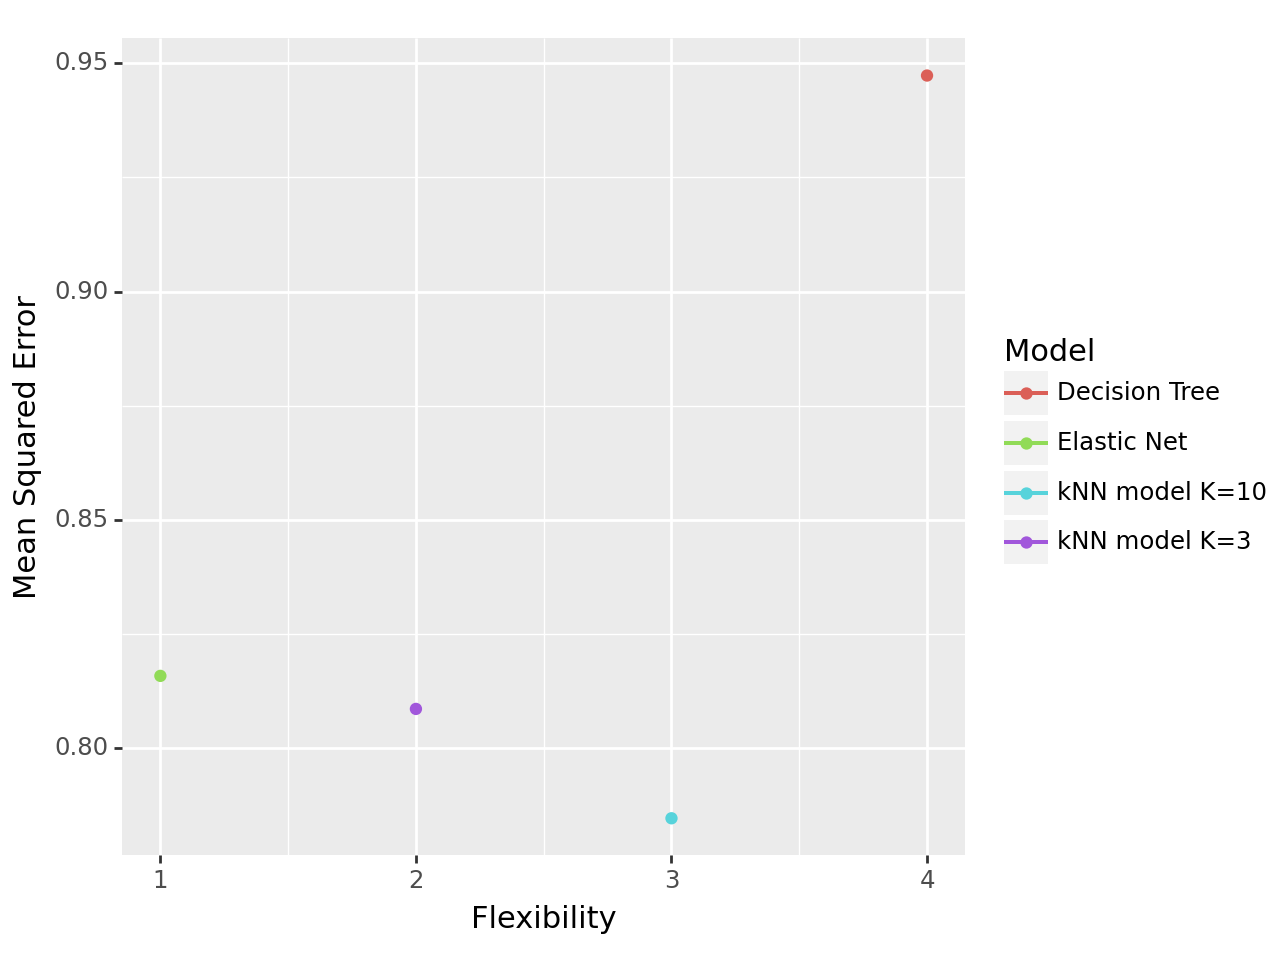

<Figure Size: (640 x 480)>

In [18]:
mse_flex_table = pd.DataFrame({"flexibility" :[1,2,3,4],
                     "mse_values" :[mse1, mse2, mse3,mse4],
                     "Model": ["Elastic Net","kNN model K=3","kNN model K=10", "Decision Tree"]
})

(ggplot(mse_flex_table ,
       aes(x="flexibility",
           y="mse_values",
           color="Model"))
+ geom_line()
+ geom_point()
+labs( x="Flexibility", y="Mean Squared Error")
)

When looking at the plot we can see that the kNN model that has a K of 10 has the lowest mse of the 4 models which means that it would be the best model.